<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example:-Evaluating-a-classifier" data-toc-modified-id="Example:-Evaluating-a-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example: Evaluating a classifier</a></span><ul class="toc-item"><li><span><a href="#classifier_score" data-toc-modified-id="classifier_score-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>classifier_score</a></span></li><li><span><a href="#Making-it-more-useful" data-toc-modified-id="Making-it-more-useful-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Making it more useful</a></span></li><li><span><a href="#And-further" data-toc-modified-id="And-further-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>And further</a></span></li></ul></li></ul></div>

# Example: Evaluating a classifier

We'd like to develop some tools that will help a user to make a domain-specific metric (DSM) to evaluate binary classifiers.

Often, off-the-shelf metrics are used, such as accuracy, precision, recall, false-positive-rate, etc. 

The number these produce may not be directly interpretable in the domain they're being applied to. 

It can be helpful to see what false negative, false positive, etc. mean in the given context, 
and associate a value (penalty or reward) to these 
that reflects how much they contribute towards or contravene the actual objective of the classifier. 

If a COVID test turns out positive, what actions will be taken and what value do their consequences have depending on whether the positive test 
was true or false? Same question for true/false negative test results. Doing this valuation then allows us to produce a formula that
evaluates the worth of a test that has more meaning that flat false positive and false negative rates. 


##  classifier_score

In [3]:
def _aligned_items(a, b):
    """Yield (k, a_value, b_value) triples for all k that are both a key of a and of b"""
    # reason for casting to dict is to make sure things like pd.Series use the right keys.
    # could also use k in a.keys() etc. to solve this.
    a = dict(a)
    b = dict(b)
    for k in a:
        if k in b:
            yield k, a[k], b[k]
            
def dot_product(a, b):
    """
    >>> dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})
    5
    """
    return sum(ak * bk for _, ak, bk in _aligned_items(a, b))


def classifier_score(confusion_count, confusion_value):
    """Compute a score for a classifier that produced the `confusion_count`, based on the given `confusion_value`.
    Meant to be curried by fixing the confusion_value dict.
    
    The function is purposely general -- it is not specific to binary classifier outcomes, or even any classifier outcomes. 
    It simply computes a normalized dot product, depending on the inputs keys to align values to multiply and 
    considering a missing key as an expression of a null value. 
    """
    return dot_product(confusion_count, confusion_value) / sum(confusion_count.values())


In [4]:
dot_product({'a': 1, 'b': 2, 'c': 3}, {'b': 4, 'c': -1, 'd': 'whatever'})

5

In [5]:
# tp, fp, fn, tn shorthands for true positive, false positive, false nagative and true nagative
confusion_count = {'tp': 30, 'fp': 10, 'fn': 2, 'tn': 8}
confusion_value = {'tp': 0, 'fp': -1, 'fn': -5, 'tn': 0}

print(f"{dot_product(confusion_count, confusion_value)=}, {sum(confusion_count.values())=}")
classifier_score(confusion_count, confusion_value)

dot_product(confusion_count, confusion_value)=-20, sum(confusion_count.values())=50


-0.4

See how accuracy can be expressed by setting values of true positive and negative to 1, and zero for all errors:

In [72]:
confusion_value = {'tp': 1, 'fp': 0, 'fn': 0, 'tn': 1}  # this corresponds to the accuracy metric!
classifier_score(confusion_count, confusion_value)

0.76

## Making it more useful

To make it more readily usable, we should offer ways to easily get a `confusion_count` dict from various common situations. 

For example, how do we get these `confusion_count`? Possibly from an array of predictions and corresponding truths.

```
truth, prediction -> confusion_count
```

These predictions might come from an array `predict_prob` of scores that were thresholded to become a binary value that we call our prediction.

```
predict_proba, threshold -> prediction
```

And those `predict_proba` scores themselves might come from a trained model who is fed `test_X` inputs, the `test_y` array being this `truth` 
that we're talking about. 

```
model, test_X -> predict_proba
test_y -> truth
```

Providing the user with a few util tools 
to get from where they are (e.g. they have a model and some test data) 
to where they want to get to (e.g. getting a classifier_score)
is nice.

Making it clear on how to use these functions to get from A to B is also nice.
This can be done through documentation, examples, and (Uncle Bob style) through careful function and variable naming, as below.

In [12]:
from collections import Counter
import numpy as np


def confusion_count(prediction, truth):
    """Get a dict containing the counts of all combinations of predicction and corresponding truth values.

    >>> confusion_count(
    ... [0, 0, 1, 0, 1, 1, 1], 
    ... [0, 0, 0, 1, 1, 1, 1]
    ... )
    Counter({(0, 0): 2, (1, 0): 1, (0, 1): 1, (1, 1): 3})
    """
    return Counter(zip(prediction, truth))


def prediction(predict_proba, threshold):
    """Get an array of predictions from thresholding the scores of predict_proba array.

    >>> prediction([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], threshold=0.5)
    array([False, False,  True,  True,  True,  True])

    """
    return np.array(predict_proba) >= threshold


def predict_proba(model, test_X):
    """Get the prediction_proba scores of a model given some test data"""
    return model.predict_proba(test_X)

Conveniently, if we use names of functions and arguments as we did above, these can be used to indicate how they all relate to each other. 

That is to say, we need nothing further to make a DAG.

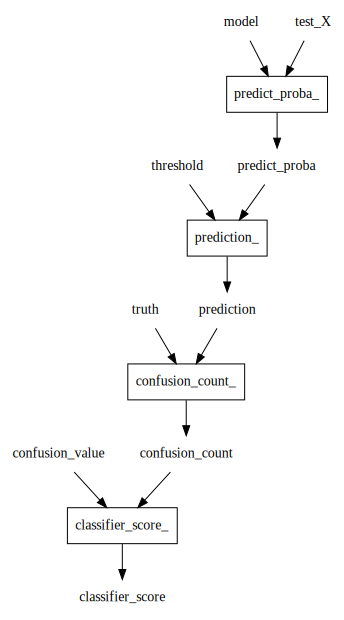

In [27]:
from meshed import DAG

dag = DAG([classifier_score, confusion_count, prediction, predict_proba])
dag.dot_digraph()

In [31]:
dag[['truth', 'prediction'], 'classifier_score']

_descendants={FuncNode(truth,prediction -> confusion_count_ -> confusion_count)}
_ancestors={FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score)}


DAG(func_nodes=[], cache_last_scope=True, parameter_merge=<function conservative_parameter_merge at 0x1192bdee0>)

In [17]:
from meshed.itools import *
from meshed.itools import descendants, ancestors

In [25]:
list(descendants(dag.graph, [prediction]))

[]

In [19]:
dag.graph

{'confusion_count': [FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score)],
 'confusion_value': [FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score)],
 FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score): ['classifier_score'],
 'truth': [FuncNode(truth,prediction -> confusion_count_ -> confusion_count)],
 'prediction': [FuncNode(truth,prediction -> confusion_count_ -> confusion_count)],
 FuncNode(truth,prediction -> confusion_count_ -> confusion_count): ['confusion_count'],
 'predict_proba': [FuncNode(predict_proba,threshold -> prediction_ -> prediction)],
 'threshold': [FuncNode(predict_proba,threshold -> prediction_ -> prediction)],
 FuncNode(predict_proba,threshold -> prediction_ -> prediction): ['prediction'],
 'model': [FuncNode(model,test_X -> predict_proba_ -> predict_proba)],
 'test_X': [FuncNode(model,test_X -> predict_proba_ -> predict_proba)],
 FuncNode(model,test_X -> predict_proba_ 

In [32]:
list(dag.graph)

['confusion_count',
 'confusion_value',
 FuncNode(confusion_count,confusion_value -> classifier_score_ -> classifier_score),
 'truth',
 'prediction',
 FuncNode(truth,prediction -> confusion_count_ -> confusion_count),
 'predict_proba',
 'threshold',
 FuncNode(predict_proba,threshold -> prediction_ -> prediction),
 'model',
 'test_X',
 FuncNode(model,test_X -> predict_proba_ -> predict_proba)]

In [26]:
from i2 import Sig

## And further

And how did we get those top inputs (`model`, `test_X` and `test_y`)? 

Well, we trained a learner on some `train_X` and `train_y` that we get by splitting some `(X, y)` arrays...

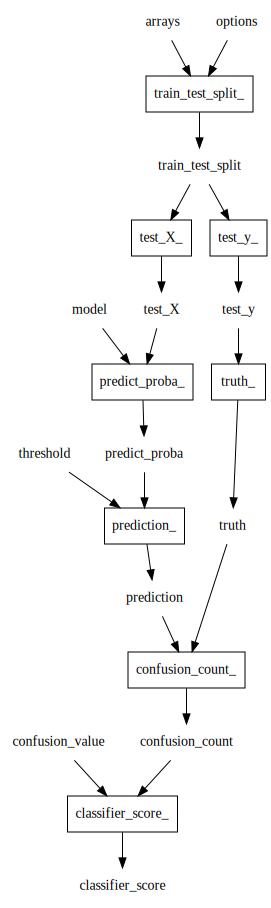

In [37]:
from sklearn.model_selection import train_test_split
from meshed import FuncNode
# from operator import itemgetter

# train_X, test_X, train_y, test_y = train_test_split(...)

def test_X(train_test_split):
    return train_test_split[1]

def test_y(train_test_split):
    return train_test_split[3]

def truth(test_y):  # to link up truth and test_y
    return test_y

bigger_dag = DAG(
    [
        classifier_score, confusion_count, prediction, predict_proba, 
        train_test_split, test_X, test_y, truth
        
    ]
)
bigger_dag.dot_digraph()

In [ ]:
bigger_dag()

In [40]:
bigger_dag[['arrays', 'options']]

DAG(func_nodes=[], cache_last_scope=True, parameter_merge=<function conservative_parameter_merge at 0x119515ca0>)